# Preparation

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  shared_drive_foldername = 'NUTRECON'
  root = '/content/drive/Shareddrives/{}/'.format(shared_drive_foldername)
  subject_figures_path = root + "4. Results/1. Subject level/"
  %pip install pandas==1.4.2
  print('Running Code in Colab')
except:
  root = 'D:/FV/Projects/NUTRECON/nutreconDrive/'
  subject_figures_path = "D:/FV/Projects/NUTRECON/Results/Subject Level/"
  print('Running Code locally')

import pandas as pd
import numpy as np
from datetime import datetime
from glob import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
#from sklearn.linear_model import LogisticRegression
from numpy.core.fromnumeric import resize
from pathlib import Path


sys.path.append(root + '1. Acquisition/notebooks')

from nutrecon import *

subject_nr = 1

_v_ = Vars()

experiment_code = _v_.experiment_code
dataPath = _v_.dataPath
sequences_dataPath = _v_.sequences_dataPath
responses_dataPath = _v_.responses_dataPath

subject_code = '{}{:03d}'.format(experiment_code, subject_nr)

subject_figures_path_ = subject_figures_path + subject_code
Path(subject_figures_path_).mkdir(parents=True, exist_ok=True)

flavorCodes = _v_.flavorCodes

imageCodes = _v_.imageCodes

imageDecoder = _v_.imageDecoder

pres_order_fileID = _v_.pres_order_fileID
pres_order_colName = _v_.pres_order_colName
flavorName_colName = _v_.flavorName_colName
flavorID_colName = _v_.flavorID_colName

pres_order_d2_fileID = _v_.pres_order_d2_fileID
pres_order_d3_fileID = _v_.pres_order_d3_fileID

flav_ratings_fileID = _v_.flav_ratings_fileID

intensity_colName = _v_.intensity_colName
novelty_colName = _v_.novelty_colName
pleasanteness_colName = _v_.pleasanteness_colName

learn_order_fileID = _v_.learn_order_fileID
learningOrder_colName = _v_.learningOrder_colName
imageName_colName = _v_.imageName_colName
imageID_colName = _v_.imageID_colName

assocTestOrder1_colName = _v_.assocTestOrder1_colName
assoc1_order_fileID = _v_.assoc1_order_fileID

assocTestOrder2_colName = _v_.assocTestOrder2_colName
assoc2_order_fileID = _v_.assoc2_order_fileID

assocTestOrder3_colName = _v_.assocTestOrder3_colName
assoc3_order_fileID = _v_.assoc3_order_fileID

neuroEconOrder1_fileID = _v_.neuroEconOrder1_fileID
neuroEconOrder2_fileID = _v_.neuroEconOrder2_fileID

conditioning_order_fileID = _v_.conditioning_order_fileID
conditioning_order_colName = _v_.conditioning_order_colName

ratings_id = _v_.ratings_id
orders_id = _v_.orders_id


learning_path = glob('{}{}*{}*'.format(sequences_dataPath, subject_code, learn_order_fileID))[0]

learnig_df = pd.read_json(learning_path).T
learnig_df[flavorName_colName].tolist()

neuroEcon_id = _v_.neuroEcon_id

neuroEcon_df = pd.read_json(glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))[0])
flavor_Cplus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['reference flavor']
flavor_Cminus = neuroEcon_df[neuroEcon_df['Trial Type'] == 'mixed_yogurt'].iloc[0]['lottery flavor']

marker_order = ['^' if flavor == flavor_Cplus else 'v' if flavor == flavor_Cminus else 'o' if flavor in learnig_df[flavorName_colName].tolist() else 'x' for flavor in list(flavorCodes.keys())]

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 83.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Running Code in Colab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Running Code in Colab


# Model evaluation and comparison

Reward types:
* Money
* CS+
* CS-

Considering the same-type trials, the model we are assessing contains two internal parameters:
* Alpha, risk aversion parameter
* Beta, slope of the logistic curve

Five model variations were chosen for evaluation and comparison, namely:
1. Three floating alphas (one per reward type) & one fixed beta
2. Single floating alpha & one fixed beta
3. Single alpha = 1 & one fixed beta
4. Three floating alphas (one per reward type) & one floating beta
5. Three floating alphas & three floating betas (one per reward type)

Another important aspect to consider is subject-level versus population level analysis. Let's start by implementing the model evaluation and comparison at a single subject level.

Model evaluation:

* cross-validation

  This procedure allows models with different numbers of parameters to be compared on the basis of the likelihood of the holdout data.

  There are several different ways to implement cross validation (k-fold, shuffle split, leave-one-out, ...)

  There are concerns about wether split datasets (e.g., train on early trials and test on late trials) are really identically distributed due to the possibility that subjects' parameters are changing.

  The holdout likelihood score is not inflated by the number of parameters in the model, since in any case zero parameters are fit to the second dataset.

* bootstrapping

  Can I compute the likelihood of holdout datasets by training on bootstapped (sampled with replacement) datasets?

* pseudo-$r^2$ 

  This is a measure of model evaluation that reports the fractional reduction in log data likelihood under pure chance.

  - pseudo-$r^2$ = 1 - L/R

  - L - log likelihood under the fit model
  
  - R - log likelihood under chance      

Model comparison:

* likelihood-ratio test (applicable only to nested models)

  null hypothesis: data are actually due to the simpler model. If the p-value is low, we can reject simpler model with confidence

  d = 2 * [ log P(D|M2, ôM2) - log P(D|M1, ôM1) ]

  The probability of a particular difference d arising under M1 follows a chi-squared distribution with a number of degrees of freedom equal to the number, n, of additional parameters in M2

## Parameter Estimation

In [ ]:
neuroEcon_paths = glob('{}{}*{}*'.format(responses_dataPath, subject_code, neuroEcon_id))

neuroEcon_path = neuroEcon_paths[0]

for neuroEcon_path in neuroEcon_paths:
  dayNeuroEcon_df = pd.read_json(neuroEcon_path)
  if neuroEcon_path == neuroEcon_paths[0]:
    neuroEcon_df = dayNeuroEcon_df
  else:
    # Changes to the godot task resulted in a
    if subject_nr == 7:
      dayNeuroEcon_df['Day'] = 'day3'
    neuroEcon_df = pd.concat([neuroEcon_df, dayNeuroEcon_df])
neuroEcon_df['reaction_time'] = neuroEcon_df['choiceTime_ms'] - neuroEcon_df['choiceStart_ms']
neuroEcon_df['Day'] = neuroEcon_df['Day'].apply(lambda day: int(day[-1]))

neuroEcon_df.reset_index(drop=True, inplace=True)
neuroEcon_df.columns

Index(['Day', 'Trial', 'Trial ID', 'Trial Type', 'User', 'block', 'choice',
       'choiceStart_ms', 'choiceTime', 'choiceTime_ms', 'feedbackTime',
       'lottery flavor', 'lottery p', 'lottery qt', 'lottery shape',
       'lottery type', 'optionTime', 'reference flavor', 'reference p',
       'reference qt', 'reference shape', 'reference type',
       'trialStartTimestamp', 'trialStart_ms', 'reaction_time'],
      dtype='object')

In [ ]:
# the model, as well as simpler nested versions, are implemented in this cell

import math
from decimal import *
getcontext().prec = 100

column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr']

optimize_cols = column_names[:6]  + [column_names[12]]

# compute expected utility for same type trials
def get_EU_(p,X, alpha, fixed_alpha):
  # to test for the simpler nested model in which alpha is 1
  if fixed_alpha:
    alpha = 1
  return p * X**alpha

# compute the probability of choosing the lottery option given the expected utilities of both choices
# logistic curve
def get_pL_(euL, euR, beta, fixed_beta):
  # set beta to a fixed value (not to be estimated, in the cases for which I am testing only the )
  if fixed_beta:
    beta = 0.3 # based on previous results for single-subject analysis

  return 1 - 1/(1 + np.exp(beta * (euL - euR)))

# according to the model selected (which varies according to the parameters choosen), compute the likelihood 
# of the evidence (choices data) given the hypothesis (internal parameters being tested in each iteration)
# observational model (the function I want to maximize; I want to see "where" is the maximum of this function, which is to say, I want to find the internal model parameters for which this function peaks...
# ...OR, which are the parameters that better explain my evidence (in this case, observed behavior in the form of trial by trial choices)) 

#-----------THIS FUNCTION IS MISSING THE CASES IN WHICH ALPHA IS FIXED AND BETA FLOATS-----------------#
def get_likelihood(row, params, cols = optimize_cols):
  ref_type = row[cols[0]]
  lott_type = row[cols[3]]

  # create to boolean variables informing on which free parameters are floating or fixed 
  # this in necessary to test simpler nested models
  fixed_alpha = 0
  fixed_beta = 0

  # more complex case, both internal model parameters float for each reward type
  if len(params) == 6:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta_money, beta_Cplus, beta_Cminus) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    betas = {'money' : beta_money,
             'C+' : beta_Cplus,
             'C-' : beta_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
    beta = betas[lott_type]
  # three floating alphas and one floating beta
  elif len(params) == 4:
    (alpha_money, alpha_Cplus, alpha_Cminus, beta) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
  # three floating alphas and fixed value for beta
  elif len(params) == 3:
    fixed_beta = 1
    beta = 0.3
    (alpha_money, alpha_Cplus, alpha_Cminus) = params
    alphas = {'money' : alpha_money,
             'C+' : alpha_Cplus,
             'C-' : alpha_Cminus}
    ref_alpha = alphas[ref_type]
    lott_alpha = alphas[lott_type]
  # single floating alpha and single floating beta:
  elif len(params) == 2:
    (alpha, beta) = params
  # single floating alpha and fixed value for beta
  elif len(params) == 1:
    fixed_beta = 1
    beta = 0.3
    (alpha) = params
    ref_alpha = alpha[0]
    lott_alpha = alpha[0]

  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  ref_EU = get_EU_(ref_p, ref_X, ref_alpha, fixed_alpha)

  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  lott_EU = get_EU_(lott_p, lott_X, lott_alpha, fixed_alpha)

  pL = get_pL_(lott_EU, ref_EU, beta, fixed_beta)

  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL
  
  return likelihood

def get_negLogLikelihood(params, args):
  df = args
  task_cols = optimize_cols

  # compute likelihood of each choice
  likelihood = df.apply(lambda row: get_likelihood(row, params, cols = task_cols), axis=1).values

  # take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))

  return negloglikelihood

def get_neuroEcon_likelihoods(params, args):
  df = args
  task_cols = optimize_cols

  # compute likelihood of each choice
  likelihoods = df.apply(lambda row: get_likelihood(row, params, cols = task_cols), axis=1).values

  df['likelihood'] = likelihoods

  return df

alpha_cPlus_d2 = 0
alpha_cMinus_d2 = 0
alpha_money_d2 = 0
alpha_cPlus_d3 = 0
alpha_cMinus_d3 = 0
alpha_money_d3 = 0

In [ ]:
# functions to compute pseudo-r2
import numpy as np

# calculate log likelihood under chance
def get_prob_rand(n_trials):
  return n_trials*np.log(0.5)

# calculate pseudo-r2 given the log likelihood of the fit data and log likelihood under chance
def pseudo_r2(probFit, probRand):
  return 1 - probFit/probRand

In [ ]:
# ------------------FIXED PARAMS-------------------#

# This functions are necessary obtain the likelihood of the holdout data for the 
# n iterations of train/test splits during cross-validation ?? need to check this

import math
from decimal import *
getcontext().prec = 100

column_names = ['reference type', 'reference qt', 'reference p',
                'lottery type', 'lottery qt', 'lottery p',
                'ref_alpha', 'lott_alpha', 'beta',
                'ref_EU', 'lott_EU', 'pL', 'choice',
                'ref_alphaEstimates', 'lott_alphaEstimates', 'betaEstimates',
                'ref_alphaEstimStdErr', 'lott_alphaEstimStdErr', 'betaEstimStdErr']

optimize_cols = column_names[:6]  + [column_names[12]]

'''def get_EU_fixed(p,X, reward_type, parsCI = parsCI):
  if reward_type == 'money':
    alpha = float(parsCI[0].split(' ')[0])
  elif reward_type == 'C+':
    alpha = float(parsCI[0].split(' ')[0])
  elif reward_type == 'C-':
    alpha = float(parsCI[0].split(' ')[0])
  return p * X**alpha'''

def get_EU_fixed(p,X, alpha = 1):
  return p * X**alpha

def get_pL_fixed(euL, euR):
  beta = 0.3 # based on previous results for single-subject analysis
  return 1 - (1/(1 + np.exp(beta * (euL - euR))))

def get_likelihood_fixed(row, cols = optimize_cols):

  ref_type = row[cols[0]]
  lott_type = row[cols[3]]
  
  choice = row[cols[6]]

  ref_X = row[cols[1]]
  ref_p = row[cols[2]]
  ref_EU = get_EU_fixed(ref_p, ref_X)

  lott_X = row[cols[4]]
  lott_p = row[cols[5]]
  lott_EU = get_EU_fixed(lott_p, lott_X)

  pL = get_pL_fixed(lott_EU, ref_EU)

  if choice == 1:
    likelihood = pL
  else:
    likelihood = 1 - pL

  return likelihood

def get_negLogLikelihood_fixed(args):

  df = args
  task_cols = optimize_cols

  # compute likelihood of each choice
  likelihood = df.apply(lambda row: get_likelihood_fixed(row, cols = task_cols), axis=1).values

  df['likelihood'] = likelihood

  # Take negative of logLikelihood for convention
  negloglikelihood = - np.sum(np.log(likelihood))

  return negloglikelihood, df

In [ ]:
# build day 2 dataset

# select only trials from day 2 neuroecononomics task
df_day2 = neuroEcon_df[neuroEcon_df['Day'] == 2]
# from the day 2 trials, select only same type trials
df_sameType_2 = df_day2[df_day2['Trial Type'] == 'same']
df_sameType_2 = df_sameType_2[df_sameType_2['choice'] != 0]
df_sameType_2['choice'] = np.where(df_sameType_2['choice'] == 2, 1, 0)

# build day 3 dataset

# select only trials from day 3 neuroecononomics task
df_day3 = neuroEcon_df[neuroEcon_df['Day'] == 3]
# from the day 3 trials, select only same type trials
df_sameType_3 = df_day3[df_day3['Trial Type'] == 'same']
df_sameType_3 = df_sameType_3[df_sameType_3['choice'] != 0]
df_sameType_3['choice'] = np.where(df_sameType_3['choice'] == 2, 1, 0)

Generate uniformly distributed blocks for cross-validation (bootstrapped dataset)

In [ ]:
def bootstrap_crossV(n_iters, x0_M, df_sameType):

  '''
  Parameters
  ----------
  n_iters : int
    Number of iterations/bootstrapped datasets created for cross-validation.
  x0_M : list
    Contains the initialized parameters for the maximum likelihood search.
  df_sameType: dataframe
    Contains all the information on the same-type trials performed in one neuroeconomics task.

  Returns
  -------
  res_cv_dict: dictionary
    This dicitonary contains the results of the maximum likelihood search, including the vectors of maximum likelihood parameters, the hessian matrix, as well as the confidence intervals.
  holdout_likelihoods: list
      This is used to track the likelihoods of the holdout datasets for all iterations.
  '''

  # create the array from which train test splits will be performed
  data = df_sameType.reset_index(drop = True)

  # create an empty dictionary to save res of every iter
  res_cv_dict = {}

  # create an empty list to append exponential of the sum of log likelihoods for the holdout dataset of each iteration
  holdout_likelihoods = []

  # perform n_iters amount of train/test splits (is this actually a bootstrapping method?)
  for iter in range(n_iters):

    # create test dataset by randomly selecting one of 6^75 random permutations
    test_dataset = data.groupby(by=['Trial ID']).sample(1)

    # create train dataset by selecting the same-type trials left from the 450 trials (75 consist in the test dataset)
    train_dataset = data[~ data.index.isin(test_dataset.index)]

    # prepare the training dataset to minimize the neg log likelihood function
    args_train = (train_dataset)

    # save the results of the minimize function (includes the estimated parameters and the hessian matrix)
    res = minimize(get_negLogLikelihood, x0_M, args=args_train)

    # save res of the current iteration in a dictionary
    res_cv_dict[f'iter_{iter}'] = res

    # from the res variable, extract the parameters that lead to maximum likelihood and use the inverse hessian to set a 95% condifence interval on the estimations
    parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

    # prepare the test dataset for which the likelihoods will be computed using the estimated parameters
    args_test = (test_dataset)

    # save only the estimated parameter values in a new variable to compute the likelihood of each choice following our model 
    if len(x0_M) == 6:
      # three floating alphas and three floating betas
      estimatedParams_train = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]), float(parsCI[2].split(' ')[0]), float(parsCI[3].split(' ')[0]), float(parsCI[4].split(' ')[0]), float(parsCI[5].split(' ')[0]))
    elif len(x0_M) == 4:
      # three floating alphas and single floating beta
      estimatedParams_train = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]), float(parsCI[2].split(' ')[0]), float(parsCI[3].split(' ')[0]))
    elif len(x0_M) == 3:
      # three floating alphas and fixed beta
      estimatedParams_train = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]), float(parsCI[2].split(' ')[0]))
    elif len(x0_M) == 2:
      # single floating alpha and single floating beta
      estimatedParams_train = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]))
    elif len(x0_M) == 1:
      # single floating alpha and fixed beta
      estimatedParams_train = float(parsCI[0].split(' ')[0]) 

    # save the choice likelihoods for the whole data set (of neuroeconomics task same-type choices)
    likelihoods_test = get_neuroEcon_likelihoods(estimatedParams_train, args_test)['likelihood']
    
    # get the number of trials in the test dataset
    n_test_trials = len(test_dataset)

    # compute the log data likelihood with the fit data
    L = np.sum(np.log(likelihoods_test))
    
    # get the exponential of the average log likelihood
    average_likelihood = round(np.exp(L/n_test_trials), 3)

    # save the average likelihood
    holdout_likelihoods += [average_likelihood]   

  return res_cv_dict, holdout_likelihoods

### Model 1

In [ ]:
# ==========================================
#                   Day 2
# ==========================================

# initialize parameters
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0

# define the arguments for the minimize function
args = (df_sameType_2)

# join the initialized parameters as the starting point for the minimize search
x0_M1 = (alphaMoney0, alphaCplus0, alphaCminus0)

# save the results of the minimize function (includes the estimated parameters and the hessian matrix)
res = minimize(get_negLogLikelihood, x0_M1, args=args)

# from the res variable, extract the parameters that lead to maximum likelihood and use the inverse hessian to set a 95% condifence interval on the estimations
parsCI_2_M1 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

# save only the estimated parameter values in a new variable to compute the likelihood of each choice following our model 
estimatedParams_d2_M1 = (float(parsCI_2_M1[0].split(' ')[0]), float(parsCI_2_M1[1].split(' ')[0]), float(parsCI_2_M1[2].split(' ')[0]))

# save the choice likelihoods for the whole data set (of day 2 task same-type choices) as numpy array
likelihoods_d2_M1 = np.array(get_neuroEcon_likelihoods(estimatedParams_d2_M1, args)['likelihood'])

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

# correct for subjects for which we only have day 2 data
if len(df_day3) > 0:
  
  args = (df_sameType_3)

  res = minimize(get_negLogLikelihood, x0_M1, args=args)

  parsCI_d3_M1 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  estimatedParams_d3_M1 = (float(parsCI_d3_M1[0].split(' ')[0]), float(parsCI_d3_M1[1].split(' ')[0]), float(parsCI_d3_M1[2].split(' ')[0])) #(alphaMoney0, alphaCplus0, alphsCminus0)
  
  likelihoods_d3_M1 = np.array(get_neuroEcon_likelihoods(estimatedParams_d3_M1, args)['likelihood'])

  print('\nResults for parameter estimation using a model with one floating alpha per reward type and a fixed value for beta')

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_2_M1[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_2_M1[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_2_M1[2]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d3_M1[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d3_M1[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d3_M1[2]))
else:
  print('\nResults for parameter estimation using a model with one floating alpha per reward type and a fixed value for beta')

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_2_M1[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_2_M1[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_2_M1[2]))
  print('\nDay 3 responses not loaded')

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557:


Results for parameter estimation using a model with one floating alpha per reward type and a fixed value for beta

Day 2 parameters:
  - alpha Money: 0.844 ± 0.165
  - alpha C+: 0.612 ± 0.063
  - alpha C-: -0.463 ± 0.999

Day 3 parameters:
  - alpha Money: 1.045 ± 0.155
  - alpha C+: 0.839 ± 0.058
  - alpha C-: -0.608 ± 1.359


#### Cross-validation

In [ ]:
# import necessary packages
import numpy as np
from sklearn.model_selection import train_test_split

# firt approach: 
# Shuffle split (80/20)
# 100 iterations

# assumption: subjects parameters are not changing within the neuroeconomics task

# create an empty list to append exponential of the sum of log likelihoods for the holdout dataset of each iteration
holdout_likelihoods_d2_M1 = []

# repeat this process for n iterations
n_iterations = 100
for n in np.arange(n_iterations):

  # split the trials in train and test datasets (80% for training, 20% for testing)
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_2, df_sameType_2['choice'], test_size=0.2)

  # prepare the training dataset to minimize the neg log likelihood function
  args_train = (X_train)

  # save the results of the minimize function (includes the estimated parameters and the hessian matrix)
  res = minimize(get_negLogLikelihood, x0_M1, args=args_train)

  # from the res variable, extract the parameters that lead to maximum likelihood and use the inverse hessian to set a 95% condifence interval on the estimations
  parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  # prepare the test dataset for which the likelihoods will be computed using the estimated parameters
  args_test = (X_test)

  # save only the estimated parameter values in a new variable to compute the likelihood of each choice following our model 
  estimatedParams_d2_train = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]), float(parsCI[2].split(' ')[0]))

  # save the choice likelihoods for the whole data set (of day 2 task same-type choices)
  likelihoods_d2_test = get_neuroEcon_likelihoods(estimatedParams_d2_train, args_test)['likelihood']
  
  # get the number of trials in the test dataset
  n_trials = len(X_test)

  # compute the log data likelihood with the fit data
  L_2 = np.sum(np.log(likelihoods_d2_test))
  
  # get the exponential of the average log likelihood
  average_likelihood = round(np.exp(L_2/n_trials), 3)

  # save the average likelihood
  holdout_likelihoods_d2_M1 += [average_likelihood]

# ==========================================
#                   Day 3
# ==========================================

# repeat process for day 3

holdout_likelihoods_d3_M1 = []

n_iterations = 100
for n in np.arange(n_iterations):
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_3, df_sameType_3['choice'], test_size=0.2)

  args_train = (X_train)

  res = minimize(get_negLogLikelihood, x0_M1, args=args_train)

  parsCI_d3 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  args_test = (X_test)

  estimatedParams_d3_train = (float(parsCI_d3[0].split(' ')[0]), float(parsCI_d3[1].split(' ')[0]), float(parsCI_d3[2].split(' ')[0]))
  
  likelihoods_d3_test = get_neuroEcon_likelihoods(estimatedParams_d3_train, args_test)['likelihood']
  
  n_trials = len(X_test)

  L_3 = np.sum(np.log(likelihoods_d3_test))
  
  average_likelihood = round(np.exp(L_3/n_trials), 3)

  holdout_likelihoods_d3_M1 += [average_likelihood]

Streaming output truncated to the last 5000 lines.
<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning: overflow encountered in exp
  return 1 - 1/(1 + np.exp(beta * (euL - euR)))
<ipython-input-3

#### Bootstrap/Cross-validation

In [ ]:
# initialize parameters
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0

# join the initialized parameters as the starting point for the minimize search
x0_M1 = (alphaMoney0, alphaCplus0, alphaCminus0)

# choose the number of iterations
n_iters = 100

# Day 2
res_cv_dict_2_M1, holdout_likelihoods_d2_M1 = bootstrap_crossV(n_iters, x0_M1, df_sameType_2)

# Day 3
res_cv_dict_3_M1, holdout_likelihoods_d3_M1 = bootstrap_crossV(n_iters, x0_M1, df_sameType_3)

Streaming output truncated to the last 5000 lines.
<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

inval

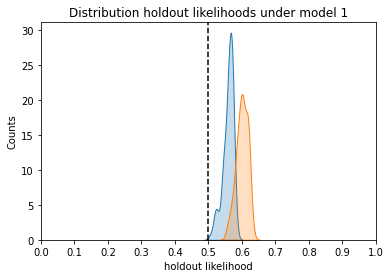

In [ ]:
import seaborn as sns

# Plot histogram of holdout data likelihood under all iterations
plt.figure()
plt.title('Distribution holdout likelihoods under model 1')
plt.xlabel('holdout likelihood')
plt.ylabel('Counts')
sns.kdeplot(holdout_likelihoods_d2_M1, fill=True)
sns.kdeplot(holdout_likelihoods_d3_M1, fill=True)
plt.xlim([0.0, 1.])
plt.axvline(x=0.5, ls='--', color = 'black')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

dist_M1 = [holdout_likelihoods_d2_M1, holdout_likelihoods_d3_M1]

labels = ['Day 2', 'Day 3']

fig = ff.create_distplot(dist_M1, group_labels = labels, bin_size = 0.01)
fig.update_layout(title_text='Three floating alphas & one fixed beta')
fig.update_xaxes(title_text='holdout dataset likelihood', range=[0., 1.])
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 800, 
    height = 400
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

#### pseudo-$r^2$

In [ ]:
n_trials = len(likelihoods_d2_M1)

# ==========================================
#                   Day 2
# ==========================================

# compute the log data likelihood with the fit data
L_2_M1 = np.sum(np.log(likelihoods_d2_M1))

# compute the log data likelihood under chance
R_2_M1 = get_prob_rand(n_trials)

print('Day 2:')

print(f'  - log likelihood of the fit data: {round(L_2_M1, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_2_M1, 3)}')

pseudoR2_2_M1 = pseudo_r2(L_2_M1, R_2_M1)
print(f'  - The pseudo-r2 for model 1 is: {round(pseudoR2_2_M1, 3)}')
print(f'  - The average likelihood level for model 1 is {round(np.exp(L_2_M1/n_trials), 3)}') # this is actually the exponential of the average log likelihood of the data and NOT the average of the raw likelihood

# ==========================================
#                   Day 3
# ==========================================

print('\nDay 3:')

# compute the log data likelihood with the fit data
L_3_M1 = np.sum(np.log(likelihoods_d3_M1))

# compute the log data likelihood under chance
R_3_M1 = get_prob_rand(n_trials)

print(f'  - log likelihood of the fit data: {round(L_3_M1, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_3_M1,3)}')

pseudoR2_3_M1 = pseudo_r2(L_3_M1, R_3_M1)
print(f'  - The pseudo-r2 for model 1 is: {round(pseudoR2_3_M1, 3)}')
print(f'  - The average likelihood level for model 1 is {round(np.exp(L_3_M1/n_trials), 3)}')

Day 2:
  - log likelihood of the fit data: -261.292
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 1 is: 0.162
  - The average likelihood level for model 1 is 0.56

Day 3:
  - log likelihood of the fit data: -226.701
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 1 is: 0.273
  - The average likelihood level for model 1 is 0.604


### Model 2

In [ ]:
# ==========================================
#                   Day 2
# ==========================================

# initialize parameters
alpha0 = 0

# define the arguments for the minimize function
args = (df_sameType_2)

# define the starting point for the minimize search
x0_M2 = (alpha0)

# save the results of the minimize function (includes the estimated parameters and the hessian matrix)
res = minimize(get_negLogLikelihood, x0_M2, args=args)

# from the res variable, extract the parameters taht lead to maximum likelihood and use inverse hessian to set a 95% confidence interval
parsCI_2_M2 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

# save only the estimated parameter value in a new variable to compute the likelihood of each choice folloing out model
estimatedParams_d2_M2 = [float(parsCI_2_M2[0].split(' ')[0])]

# save the choice likelihoods for the whole data set (of day 2 task same-type choices) as numpy array
likelihoods_d2_M2 = np.array(get_neuroEcon_likelihoods(estimatedParams_d2_M2, args)['likelihood'])

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

# correct the subjects for which we only have day 2 data
if len(df_day3) > 0:
  
  args = (df_sameType_3)

  res = minimize(get_negLogLikelihood, x0_M2, args=args)

  parsCI_d3_M2 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  estimatedParams_d3_M2 = [(float(parsCI_d3_M2[0].split(' ')[0]))]

  likelihoods_d3_M2 = np.array(get_neuroEcon_likelihoods(estimatedParams_d3_M2, args)['likelihood'])

  print('\nResults for parameter estimation using a model with a single floating alpha and a fixed value for beta')

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha', parsCI_2_M2[0]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('alpha', parsCI_d3_M2[0]))
else:
  print('\nResults for parameter estimation using a model with a single floating alpha and a fixed value for beta')
  
  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha', parsCI_2_M2[0]))
  print('\nDay 3 responses not loaded')

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log




Results for parameter estimation using a model with a single floating alpha and a fixed value for beta

Day 2 parameters:
  - alpha: 0.3 ± 0.13

Day 3 parameters:
  - alpha: 0.228 ± 0.236


#### Cross-validation

In [ ]:
# assumption: subjects parameters are not changing within the neuroeconomics task

import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
#                   Day 2
# ==========================================

# create an empty list to append exponential of the sum of log likelihoods for the holdout dataset
holdout_likelihoods_d2_M2 = []

# repeat this process for n number of iterations
n_iterations = 100
for n in np.arange(n_iterations):

  # split the trials in train and test datasets (80% for training, 20% for testing)
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_2, df_sameType_2['choice'], test_size=0.2)

  # prepare the training dataset to minimize the neg log likelihood function
  args_train = (X_train)

  # save the results of the minimize function (includes the estimated parameters and the hessian matrix)
  res = minimize(get_negLogLikelihood, x0_M2, args=args_train)

  # save the choice likelihoods for the whole data set (of day 2 task same-type choices)
  parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  # prepare the test dataset for which the likelihoods will be computed using the estimated parameters  
  args_test = (X_test)

  # save only the estimated parameter values in a new variable to compute the likelihood of each choice following our model 
  estimatedParams_d2_train = [(float(parsCI[0].split(' ')[0]))]

  # save the choice likelihoods for the whole data set (of day 2 task same-type choices)
  likelihoods_d2_test = get_neuroEcon_likelihoods(estimatedParams_d2_train, args_test)['likelihood']

  # get the number of trials in the test dataset  
  n_trials = len(X_test)

  # compute the log data likelihood with the fit data
  L_2 = np.sum(np.log(likelihoods_d2_test))

  # get the exponential of the average log likelihood
  average_likelihood = round(np.exp(L_2/n_trials), 3)

  # save the average likelihood
  holdout_likelihoods_d2_M2 += [average_likelihood]

# ==========================================
#                   Day 3
# ==========================================


holdout_likelihoods_d3_M2 = []

n_iterations = 100
for n in np.arange(n_iterations):
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_3, df_sameType_3['choice'], test_size=0.2)

  args_train = (X_train)

  res = minimize(get_negLogLikelihood, x0_M2, args=args_train)

  parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  args_test = (X_test)

  estimatedParams_d3_train = [(float(parsCI[0].split(' ')[0]))]
  likelihoods_d3_test = get_neuroEcon_likelihoods(estimatedParams_d3_train, args_test)['likelihood']
  
  n_trials = len(X_test)
  # compute the log data likelihood with the fit data
  L_3 = np.sum(np.log(likelihoods_d3_test))
  average_likelihood = round(np.exp(L_3/n_trials), 3)

  holdout_likelihoods_d3_M2 += [average_likelihood]

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/sci

#### Bootstrap/Cross-validation

In [ ]:
# initialize parameters
alpha0 = 0

# define the starting point for the minimize search
x0_M2 = (alpha0)

# choose the number of iterations
n_iters = 10

# Day 2
res_cv_dict_2_M2, holdout_likelihoods_d2_M2 = bootstrap_crossV(n_iters, x0_M2, df_sameType_2)

# Day 3
res_cv_dict_3_M2, holdout_likelihoods_d3_M2 = bootstrap_crossV(n_iters, x0_M2, df_sameType_3)

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning: divide by zero encountered in log
  negloglikelihood = - np.sum(np.log(likelihood))


TypeError: ignored

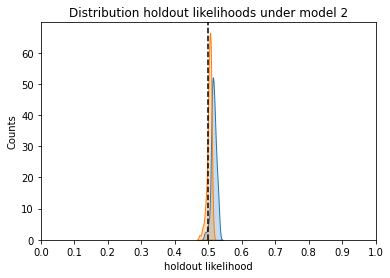

In [ ]:
import seaborn as sns

# Plot histogram of holdout daat likelihood under all iterations
plt.figure()
plt.title('Distribution holdout likelihoods under model 2')
plt.xlabel('holdout likelihood')
plt.ylabel('Counts')
sns.kdeplot(holdout_likelihoods_d2_M2, fill=True)
sns.kdeplot(holdout_likelihoods_d3_M2, fill=True)
plt.xlim([0., 1.])
plt.axvline(x=0.5, ls='--', color = 'black')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

dist_M2 = [holdout_likelihoods_d2_M2, holdout_likelihoods_d3_M2]

labels = ['Day 2', 'Day 3']

fig = ff.create_distplot(dist_M2, group_labels = labels, bin_size = 0.01)
fig.update_layout(title_text='One floating alpha & one fixed beta')
fig.update_xaxes(title_text='holdout dataset likelihood', range=[0., 1.])
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 800, 
    height = 400
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

#### pseudo-$r^2$

In [ ]:
n_trials = len(likelihoods_d2_M2)

# ==========================================
#                   Day 2
# ==========================================

# compute the log data likelihood with the fit data
L_2_M2 = np.sum(np.log(likelihoods_d2_M2))

# compute the log data likelihood under chance
R_2_M2 = get_prob_rand(n_trials)

print('\nDay 2:')

print(f'  - log likelihood of the fit data: {round(L_2_M2, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_2_M2, 3)}')

pseudoR2_2 = pseudo_r2(L_2_M2, R_2_M2)
print(f'  - The pseudo-r2 for model 2 is: {round(pseudoR2_2, 3)}')
print(f'  - The average likelihood level for model 2 is {round(np.exp(L_2_M2/n_trials), 3)}')

# ==========================================
#                   Day 3
# ==========================================

# compute the log data likelihood with the fit data
L_3_M2 = np.sum(np.log(likelihoods_d3_M2))

# compute the log data likelihood under chance
R_3_M2 = get_prob_rand(n_trials)

print('\nDay 3:')

print(f'  - log likelihood of the fit data: {round(L_3_M2, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_3_M2, 3)}')

pseudoR2_3 = pseudo_r2(L_3_M2, R_3_M2)
print(f'  - The pseudo-r2 for model 2 is: {round(pseudoR2_3, 3)}')
print(f'  - The average likelihood level for model 2 is {round(np.exp(L_3_M2/n_trials), 3)}')


Day 2:
  - log likelihood of the fit data: -296.385
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 2 is: 0.05
  - The average likelihood level for model 2 is 0.518

Day 3:
  - log likelihood of the fit data: -305.408
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 2 is: 0.021
  - The average likelihood level for model 2 is 0.507


### Model 3

In [ ]:
# for model 3, both alpha and beta are fixed. So, no parameter estimation will be performed.
# alpha = 1
# beta = 0.3

# ==========================================
#                   Day 2
# ==========================================

args = (df_sameType_2)

negLoglikelihood_d2_M3, df_2_M3 = get_negLogLikelihood_fixed(args)

likelihoods_d2_M3 = np.array(df_2_M3['likelihood'])

# ==========================================
#                   Day 3
# ==========================================

args = (df_sameType_3)

negLoglikelihood_d3_M3, df_3_M3 = get_negLogLikelihood_fixed(args)

likelihoods_d3_M3 = np.array(df_3_M3['likelihood'])

<ipython-input-5-82c9319ed76e>:70: RuntimeWarning:

divide by zero encountered in log

<ipython-input-5-82c9319ed76e>:70: RuntimeWarning:

divide by zero encountered in log



#### Cross-validation

#### pseudo-$r^2$

In [ ]:
n_trials = len(likelihoods_d2_M3)

# ==========================================
#                   Day 2
# ==========================================

# compute the log data likelihood with the fit data
L_2_M3 = np.sum(np.log(likelihoods_d2_M3))

# compute the log data likelihood under chance
R_2_M3 = get_prob_rand(n_trials)

print('\nDay 2:')

print(f'  - log likelihood of the fit data: {round(L_2_M3, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_2_M3, 3)}')

pseudoR2_2 = pseudo_r2(L_2_M3, R_2_M3)
print(f'  - The pseudo-r2 for model 2 is: {round(pseudoR2_2, 3)}')
print(f'  - The average likelihood level for model 2 is {round(np.exp(L_2_M3/n_trials), 3)}')

# ==========================================
#                   Day 3
# ==========================================

# compute the log data likelihood with the fit data
L_3_M3 = np.sum(np.log(likelihoods_d3_M3))

# compute the log data likelihood under chance
R_3_M3 = get_prob_rand(n_trials)

print('\nDay 3:')

print(f'  - log likelihood of the fit data: {round(L_3_M3, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_3_M3, 3)}')

pseudoR2_3 = pseudo_r2(L_3_M3, R_3_M3)
print(f'  - The pseudo-r2 for model 2 is: {round(pseudoR2_3, 3)}')
print(f'  - The average likelihood level for model 2 is {round(np.exp(L_3_M3/n_trials), 3)}')


Day 2:
  - log likelihood of the fit data: -inf
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 2 is: -inf
  - The average likelihood level for model 2 is 0.0

Day 3:
  - log likelihood of the fit data: -inf
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 2 is: -inf
  - The average likelihood level for model 2 is 0.0


<ipython-input-22-8f092554629f>:8: RuntimeWarning:

divide by zero encountered in log

<ipython-input-22-8f092554629f>:27: RuntimeWarning:

divide by zero encountered in log



### Model 4

In [ ]:
# ==========================================
#                   Day 2
# ==========================================

# initialize parameters
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0
beta0 = 0

# define the arguments for the minimize function 
args = (df_sameType_2)

# join the initialize parameters as the starting point for the minimize search
x0_M4 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)

# save the results of the minimize function (includes estimated parameters and hessian matrix)
res = minimize(get_negLogLikelihood, x0_M4, args=args)

# from the res variable, extract the parameters that lead to maximum likelihood and use the inverse hessian to set a 95% confidence interval on the estimates
parsCI_2_M4 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

# save only the estimated parameter values in a new variable to compute the likelihood of choice following our model 
estimatedParams_d2_M4 = (float(parsCI_2_M4[0].split(' ')[0]), float(parsCI_2_M4[1].split(' ')[0]), float(parsCI_2_M4[2].split(' ')[0]), float(parsCI_2_M4[3].split(' ')[0]))

# save the choice likelihoods for the whole data set (of day 2 task same-type choices) as numpy array
likelihoods_d2_M4 = np.array(get_neuroEcon_likelihoods(estimatedParams_d2_M4, args)['likelihood'])

# ==========================================
#                   Day 3
# ==========================================

if len(df_day3) > 0:
  
  args = (df_sameType_3)

  res = minimize(get_negLogLikelihood, x0_M4, args=args)

  parsCI_d3_M4 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  estimatedParams_d3_M4 = (float(parsCI_d3_M4[0].split(' ')[0]), float(parsCI_d3_M4[1].split(' ')[0]), float(parsCI_d3_M4[2].split(' ')[0]), float(parsCI_d3_M4[3].split(' ')[0]))

  likelihoods_d3_M4 = get_neuroEcon_likelihoods(estimatedParams_d3_M4, args)['likelihood']

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_2_M4[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_2_M4[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_2_M4[2]))
  print('  - {}: {}'.format('beta', parsCI_2_M4[3]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d3_M4[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d3_M4[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d3_M4[2]))
  print('  - {}: {}'.format('beta', parsCI_d3_M4[3]))
else:
  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_2_M4[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_2_M4[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_2_M4[2]))
  print('  - {}: {}'.format('beta', parsCI_2_M4[3]))
  print('\nDay 3 responses not loaded')

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:



Day 2 parameters:
  - alpha Money: 0.473 ± 0.086
  - alpha C+: 0.374 ± 0.068
  - alpha C-: -0.773 ± 0.552
  - beta: 2.02 ± 0.509

Day 3 parameters:
  - alpha Money: 0.784 ± 0.155
  - alpha C+: 0.728 ± 0.067
  - alpha C-: -0.698 ± 0.902
  - beta: 0.736 ± 0.271


#### Cross-validation

In [ ]:
# assumption: subjects parameters are not changing within the neuroeconomics task

import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
#                   Day 2
# ==========================================


# append exponential of the sum of log likelihoods for the holdout dataset
holdout_likelihoods_d2_M4 = []

# repeat this process for n number of iterations
n_iterations = 100
for n in np.arange(n_iterations):

  # split the trials in train and test datasets (80% for training, 20% for testing)
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_2, df_sameType_2['choice'], test_size=0.2)

  # prepare the training dataset to minimize the neg log likelihood function
  args_train = (X_train)

  # save the results of the minimize function (includes the estimated parameters and the hessian matrix)
  res = minimize(get_negLogLikelihood, x0_M4, args=args_train)

  # from the res variable, extract the parameters that lead to maximum likelihood and use the inverse hessian to set a 95% confidence interval on the estimates
  parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  # prepare the test dataset for which the likelihood will be computed using the estimated parameters
  args_test = (X_test)

  # save only the estimated parameter values in a new variable to compute the likelihood of each choice following our model
  estimatedParams_d2_train_M4 = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]), float(parsCI[2].split(' ')[0]), float(parsCI[3].split(' ')[0]))

  # save the choice likelihoods for the whole data set (of day 2 task same-type choices)
  likelihoods_d2_test_M4 = get_neuroEcon_likelihoods(estimatedParams_d2_train_M4, args_test)['likelihood']
  
  # get the number of trials in the test dataset
  n_trials = len(X_test)

  # compute the log data likelihood with the fit data
  L_2_M4 = np.sum(np.log(likelihoods_d2_test_M4))
  
  # get the exponential of the average log likelihood
  average_likelihood = round(np.exp(L_2_M4/n_trials), 3)

  # save the average likelihood
  holdout_likelihoods_d2_M4 += [average_likelihood]

# ==========================================
#                   Day 3
# ==========================================

# append exponential of the sum of log likelihoods for the holdout dataset
holdout_likelihoods_d3_M4 = []

# repeat this process for n number of iterations
n_iterations = 100
for n in np.arange(n_iterations):

  X_train, X_test, y_train, y_test = train_test_split(df_sameType_3, df_sameType_3['choice'], test_size=0.2)

  args_train = (X_train)

  res = minimize(get_negLogLikelihood, x0_M4, args=args_train)

  parsCI_d3 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  args_test = (X_test)

  estimatedParams_d3_train_M4 = (float(parsCI_d3[0].split(' ')[0]), float(parsCI_d3[1].split(' ')[0]), float(parsCI_d3[2].split(' ')[0]), float(parsCI_d3[3].split(' ')[0]))

  likelihoods_d3_test_M4 = get_neuroEcon_likelihoods(estimatedParams_d3_train_M4, args_test)['likelihood']
  
  n_trials = len(X_test)

  L_3_M4 = np.sum(np.log(likelihoods_d3_test_M4))
  
  average_likelihood = round(np.exp(L_3_M4/n_trials), 3)

  holdout_likelihoods_d3_M4 += [average_likelihood]

Streaming output truncated to the last 5000 lines.
<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide b

#### Bootstrap/Cross-validation

In [ ]:
# initialize parameters
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0
beta0 = 0

# join the initialized parameters as the starting point for the minimize search
x0_M4 = (alphaMoney0, alphaCplus0, alphaCminus0, beta0)

# choose the number of iterations
n_iters = 100

# Day 2
res_cv_dict_2_M4, holdout_likelihoods_d2_M4 = bootstrap_crossV(n_iters, x0_M4, df_sameType_2)

# Day 3
res_cv_dict_3_M4, holdout_likelihoods_d3_M4 = bootstrap_crossV(n_iters, x0_M4, df_sameType_3)

Streaming output truncated to the last 5000 lines.
<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-in

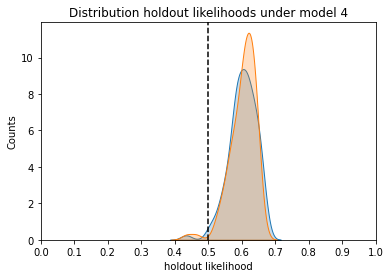

In [ ]:
import seaborn as sns

# Plot histogram of holdout daat likelihood under all iterations
plt.figure()
plt.title('Distribution holdout likelihoods under model 4')
plt.xlabel('holdout likelihood')
plt.ylabel('Counts')
sns.kdeplot(holdout_likelihoods_d2_M4, fill=True)
sns.kdeplot(holdout_likelihoods_d3_M4, fill=True)
plt.xlim([0., 1.])
plt.axvline(x=0.5, ls='--', color = 'black')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

dist_M4 = [holdout_likelihoods_d2_M4, holdout_likelihoods_d3_M4]

labels = ['Day 2', 'Day 3']

fig = ff.create_distplot(dist_M4, group_labels = labels, bin_size = 0.01)
fig.update_layout(title_text='Three floating alphas & one floating beta')
fig.update_xaxes(title_text='holdout dataset likelihood', range=[0., 1.])
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 800, 
    height = 400
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

#### pseudo-$r^2$

In [ ]:
n_trials = len(likelihoods_d2_M4)

# ==========================================
#                   Day 2
# ==========================================

# compute the log data likelihood with the fit data
L_2_M4 = np.sum(np.log(likelihoods_d2_M4))
# compute the log data likelihood under chance
R_2_M4 = get_prob_rand(n_trials)

print('Day 2:')

print(f'  - log likelihood of the fit data: {round(L_2_M4, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_2_M4, 3)}')

pseudoR2_2 = pseudo_r2(L_2_M4, R_2_M4)
print(f'  - The pseudo-r2 for model 4 is: {round(pseudoR2_2, 3)}')
print(f'  - The average likelihood level for model 4 is {round(np.exp(L_2_M4/n_trials), 3)}') # this is actually the exponential of the average log likelihood of the data and NOT the average of the raw likelihood

# ==========================================
#                   Day 3
# ==========================================

print('\nDay 3:')

# compute the log data likelihood with the fit data
L_3_M4 = np.sum(np.log(likelihoods_d3_M4))
# compute the log data likelihood under chance
R_3_M4 = get_prob_rand(n_trials)

print(f'  - log likelihood of the fit data: {round(L_3_M4, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_3_M4,3)}')

pseudoR2_3 = pseudo_r2(L_3_M4, R_3_M4)
print(f'  - The pseudo-r2 for model 4 is: {round(pseudoR2_3, 3)}')
print(f'  - The average likelihood level for model 4 is: {round(np.exp(L_3_M4/n_trials), 3)}')

Day 2:
  - log likelihood of the fit data: -223.49
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 4 is: 0.283
  - The average likelihood level for model 4 is 0.609

Day 3:
  - log likelihood of the fit data: -219.897
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 4 is: 0.295
  - The average likelihood level for model 4 is: 0.613


### Model 5

In [ ]:
# ==========================================
#                   Day 2
# ==========================================

# initialize parameters
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0
betaMoney0 = 0
betaCplus0 = 0
betaCminus0 = 0

# define the arguments for the minimize function
args = (df_sameType_2)

# join the initialized parameters as the starting point for the minimize search
x0_M5 = (alphaMoney0, alphaCplus0, alphaCminus0, betaMoney0, betaCplus0, betaCminus0)

# save the results of the minimize function (includes the estimated parameters and the hessian matrix)
res = minimize(get_negLogLikelihood, x0_M5, args=args )

# from the res variable, extract the parameters that lead to maximum likelihood and use the inverse hessian to set a 95% confidence interval on the estimations
parsCI_2_M5 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

# save only the estimated parmeter values in a new variable to compute the likelihood of each choice following our model
estimatedParams_d2_M5 = (float(parsCI_2_M5[0].split(' ')[0]), float(parsCI_2_M5[1].split(' ')[0]), float(parsCI_2_M5[2].split(' ')[0]), float(parsCI_2_M5[3].split(' ')[0]), float(parsCI_2_M5[4].split(' ')[0]), float(parsCI_2_M5[5].split(' ')[0]))

# save the choice likelihoods for the whole dat set (of day 2 task same-type choices) as numpy array 
likelihoods_d2_M5 = np.array(get_neuroEcon_likelihoods(estimatedParams_d2_M5, args)['likelihood'])

# ==========================================
#                   Day 3
# ==========================================

if len(df_day3) > 0:
  
  args = (df_sameType_3)

  res = minimize(get_negLogLikelihood, x0_M5, args=args)

  parsCI_d3_M5 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  estimatedParams_d3_M5 = (float(parsCI_d3_M5[0].split(' ')[0]), float(parsCI_d3_M5[1].split(' ')[0]), float(parsCI_d3_M5[2].split(' ')[0]), float(parsCI_d3_M5[3].split(' ')[0]), float(parsCI_d3_M5[4].split(' ')[0]), float(parsCI_d3_M5[5].split(' ')[0]))
  
  likelihoods_d3_M5 = np.array(get_neuroEcon_likelihoods(estimatedParams_d3_M5, args)['likelihood'])

  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_2_M5[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_2_M5[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_2_M5[2]))
  print('  - {}: {}'.format('beta Money', parsCI_2_M5[3]))
  print('  - {}: {}'.format('beta C+', parsCI_2_M5[4]))
  print('  - {}: {}'.format('beta C-', parsCI_2_M5[5]))

  print('\nDay 3 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_d3_M5[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_d3_M5[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_d3_M5[2]))
  print('  - {}: {}'.format('beta Money', parsCI_d3_M5[3]))
  print('  - {}: {}'.format('beta C+', parsCI_d3_M5[4]))
  print('  - {}: {}'.format('beta C-', parsCI_d3_M5[5]))
else:
  print('\nDay 2 parameters:')
  print('  - {}: {}'.format('alpha Money', parsCI_2_M5[0]))
  print('  - {}: {}'.format('alpha C+', parsCI_2_M5[1]))
  print('  - {}: {}'.format('alpha C-', parsCI_2_M5[2]))
  print('  - {}: {}'.format('beta Money', parsCI_2_M5[3]))
  print('  - {}: {}'.format('beta C+', parsCI_2_M5[4]))
  print('  - {}: {}'.format('beta C-', parsCI_2_M5[5]))
  print('\nDay 3 responses not loaded')

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:



Day 2 parameters:
  - alpha Money: 0.422 ± 0.053
  - alpha C+: 0.45 ± 0.072
  - alpha C-: 0.776 ± 0.112
  - beta Money: 5.67 ± 1.889
  - beta C+: 1.054 ± 0.393
  - beta C-: -0.157 ± 0.097

Day 3 parameters:
  - alpha Money: 0.539 ± 0.061
  - alpha C+: 0.79 ± 0.084
  - alpha C-: 0.82 ± 0.094
  - beta Money: 4.817 ± 1.527
  - beta C+: 0.44 ± 0.194
  - beta C-: -0.29 ± 0.145


#### Cross-validation

In [ ]:
# assumption: subjects parameters are not changing within the neuroeconomics task

import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
#                   Day 2
# ==========================================

# create an empty list to append exponential of the sum of log likelihoods for the holdout dataset of each iteration
holdout_likelihoods_d2_M5 = []

# repeat this process for n number of iterations
n_iterations = 100
for n in np.arange(n_iterations):

  # split the trials in train and test datasets (80% training, 20% for testing)
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_2, df_sameType_2['choice'], test_size=0.2)

  # prepare the training dataset to minimize the neg log likelihood function
  args_train = (X_train)

  # save the results of the minimize function (includes the estimated parameters and the hessian matrix)
  res = minimize(get_negLogLikelihood, x0_M5, args=args_train)

  # from the res variable, extract the paramters that lead to maximum likelihood and use the inverse hessian to set a 95% confidence interval on the estimates
  parsCI = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  # prepare the test dataset for which the likelihoods will be computed using the estimated parameters
  args_test = (X_test)

  # save only the estimated parameter values in a new variable to compute the likelihood of each hcoice following our model
  estimatedParams_d2_train_M5 = (float(parsCI[0].split(' ')[0]), float(parsCI[1].split(' ')[0]), float(parsCI[2].split(' ')[0]), float(parsCI[3].split(' ')[0]), float(parsCI[4].split(' ')[0]), float(parsCI[5].split(' ')[0]))
  
  # save the choice likelihoods for the whole dataset (of  day 2 task same-type choices)
  likelihoods_d2_test_M5 = get_neuroEcon_likelihoods(estimatedParams_d2_train_M5, args_test)['likelihood']
  
  # get the number of trials in the test dataset
  n_trials = len(X_test)

  # compute the log data likelihood with the fit data
  L_2_M5 = np.sum(np.log(likelihoods_d2_test_M5))

  # get the exponential of the average log likelihood
  average_likelihood = round(np.exp(L_2_M5/n_trials), 3)

  # save the average likelihood
  holdout_likelihoods_d2_M5 += [average_likelihood]

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

holdout_likelihoods_d3_M5 = []

n_iterations = 100
for n in np.arange(n_iterations):
  X_train, X_test, y_train, y_test = train_test_split(df_sameType_3, df_sameType_3['choice'], test_size=0.2)

  args_train = (X_train)

  res = minimize(get_negLogLikelihood, x0_M5, args=args_train)

  parsCI_d3 = ['{} \xb1 {}'.format(round(res.x[p],3), round(1.96*np.sqrt(np.diag(res.hess_inv))[p],3)) for p in range(len(res.x))]

  args_test = (X_test)

  estimatedParams_d3_train_M5 = (float(parsCI_d3[0].split(' ')[0]), float(parsCI_d3[1].split(' ')[0]), float(parsCI_d3[2].split(' ')[0]), float(parsCI_d3[3].split(' ')[0]), float(parsCI_d3[4].split(' ')[0]), float(parsCI_d3[5].split(' ')[0]))
  
  likelihoods_d3_test_M5 = get_neuroEcon_likelihoods(estimatedParams_d3_train_M5, args_test)['likelihood']
  
  n_trials = len(X_test)

  L_3_M5 = np.sum(np.log(likelihoods_d3_test_M5))

  average_likelihood = round(np.exp(L_3_M5/n_trials), 3)

  holdout_likelihoods_d3_M5 += [average_likelihood]

Streaming output truncated to the last 5000 lines.
<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-3-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<

#### Bootstrap/Cross-validation

In [ ]:
# initialize parameters
alphaMoney0 = 0
alphaCplus0 = 0
alphaCminus0 = 0
betaMoney0 = 0
betaCplus0 = 0
betaCminus0 = 0

# join the initialized parameters as the starting point for the minimize search
x0_M5 = (alphaMoney0, alphaCplus0, alphaCminus0, betaMoney0, betaCplus0, betaCminus0)

# choose the number of iterations
n_iters = 100

# Day 2
res_cv_dict_2_M5, holdout_likelihoods_d2_M5 = bootstrap_crossV(n_iters, x0_M5, df_sameType_2)

# Day 3
res_cv_dict_3_M5, holdout_likelihoods_d3_M5 = bootstrap_crossV(n_iters, x0_M5, df_sameType_3)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-41-f69e5b1ca7dc>:30: RuntimeWarning:

overflow encountered in exp

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipython-input-41-f69e5b1ca7dc>:115: RuntimeWarning:

divide by zero encountered in log

<ipy

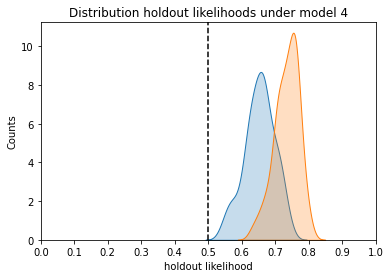

In [ ]:
import seaborn as sns

# Plot histogram of holdout daat likelihood under all iterations
plt.figure()
plt.title('Distribution holdout likelihoods under model 4')
plt.xlabel('holdout likelihood')
plt.ylabel('Counts')
sns.kdeplot(holdout_likelihoods_d2_M5, fill=True)
sns.kdeplot(holdout_likelihoods_d3_M5, fill=True)
plt.xlim([0., 1.])
plt.axvline(x=0.5, ls='--', color = 'black')
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

dist_M5 = [holdout_likelihoods_d2_M5, holdout_likelihoods_d3_M5]

labels = ['Day 2', 'Day 3']

fig = ff.create_distplot(dist_M5, group_labels = labels, bin_size = 0.01)
fig.update_layout(title_text='Three floating alphas & three floating betas')
fig.update_xaxes(title_text='holdout dataset likelihood', range=[0., 1.])
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 800, 
    height = 400
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

#### pseudo-$r^2$

In [ ]:
n_trials = len(likelihoods_d2_M5)

# ==========================================
#                   Day 2
# ==========================================

# compute the log data likelihood with the fit data
L_2_M5 = np.sum(np.log(likelihoods_d2_M5))
# compute the log data likelihood under chance
R_2_M5 = get_prob_rand(n_trials)

print('Day 2:')

print(f'  - log likelihood of the fit data: {round(L_2_M5, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_2_M5, 3)}')

pseudoR2_2 = pseudo_r2(L_2_M5, R_2_M5)
print(f'  - The pseudo-r2 for model 4 is: {round(pseudoR2_2, 3)}')
print(f'  - The average likelihood level for model 4 is {round(np.exp(L_2_M5/n_trials), 3)}') # this is actually the exponential of the average log likelihood of the data and NOT the average of the raw likelihood

# ==========================================
#                   Day 3
# ==========================================

print('\nDay 3:')

# compute the log data likelihood with the fit data
L_3_M5 = np.sum(np.log(likelihoods_d3_M5))
# compute the log data likelihood under chance
R_3_M5 = get_prob_rand(n_trials)

print(f'  - log likelihood of the fit data: {round(L_3_M5, 3)}')
print(f'  - log likelihood for a random chooser: {round(R_3_M5,3)}')

pseudoR2_3 = pseudo_r2(L_3_M5, R_3_M5)
print(f'  - The pseudo-r2 for model 4 is: {round(pseudoR2_3, 3)}')
print(f'  - The average likelihood level for model 4 is: {round(np.exp(L_3_M5/n_trials), 3)}')

Day 2:
  - log likelihood of the fit data: -177.274
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 4 is: 0.432
  - The average likelihood level for model 4 is 0.674

Day 3:
  - log likelihood of the fit data: -139.659
  - log likelihood for a random chooser: -311.916
  - The pseudo-r2 for model 4 is: 0.552
  - The average likelihood level for model 4 is: 0.733


## Likelihood-ratio tests (nested models)

#### Model 1 vs Model 2

In [ ]:
import numpy as np
from scipy.stats import chi2

# ==========================================
#                   Day 2
# ==========================================

# set parameters for the chi-square distribution

# number of additional parameters in M2 relative to M1
n_M1_M2 = 2 

# compute d value for 95% significance (same for day 3)
critical_d_M1_M2 = chi2.ppf(0.95, df=n_M1_M2)

# compute twice the difference in log likelihoods
d_d2_M1_M2 = 2 * (L_2_M1 - L_2_M2)

# compute the p-value of the test (a difference d or larger arising due to chance) is one minus the chi-square cumulative distribution at d
p_value_d2_M1_M2 = 1 - chi2.cdf(x=d_d2_M1_M2, df=n_M1_M2)

# print the computed values
print('three floating alphas & one fixed beta VS one floating alpha & one fixed beta\n')
print('Day 2:')
print(f'  - p-value: {p_value_d2_M1_M2}')
print(f'  - d: {round(d_d2_M1_M2, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M1_M2, 2)}\n')

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

d_d3_M1_M2 = 2 * (L_3_M1 - L_3_M2)

p_value_d3_M1_M2 = 1 - chi2.cdf(x=d_d3_M1_M2, df=n_M1_M2)

print('Day 3:')
print(f'  - p-value: {p_value_d3_M1_M2}')
print(f'  - d: {round(d_d3_M1_M2, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M1_M2, 2)}\n')

three floating alphas & one fixed beta VS one floating alpha & one fixed beta

Day 2:
  - p-value: 5.551115123125783e-16
  - d: 70.187
  - critical d value for 95% significance: 5.99

Day 3:
  - p-value: 0.0
  - d: 157.415
  - critical d value for 95% significance: 5.99



#### Model 4 vs Model 1 

In [ ]:
# ==========================================
#                   Day 2
# ==========================================

# set parameters for the chi-square distribution

# number of additional parameters in M4 relative to M1
n_M4_M1 = 1 

# compute d value for 95% significance
critical_d_M4_M1 = chi2.ppf(0.95, df=n_M4_M1)

# compute twice the difference in log likelihoods
d_d2_M4_M1 = 2 * (L_2_M4 - L_2_M1)

# compute the p-value of the test (a difference d or larger arising due to chance) is one minus the chi-square cumulative distribution at d
p_value_d2_M4_M1 = 1 - chi2.cdf(x=d_d2_M4_M1, df=n_M4_M1)

# print the computed values
print('three floating alphas & one floating beta VS three floating alphas & one fixed beta\n')
print('Day 2:')
print(f'  - p-value: {p_value_d2_M4_M1}')
print(f'  - d: {round(d_d2_M4_M1, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M4_M1, 2)}\n')

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

d_d3_M4_M1 = 2 * (L_3_M4 - L_3_M1)

p_value_d3_M4_M1 = 1 - chi2.cdf(x=d_d3_M4_M1, df=n_M4_M1)

print('Day 3:')
print(f'  - p-value: {p_value_d3_M4_M1}')
print(f'  - d: {round(d_d3_M4_M1, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M4_M1, 2)}\n')

three floating alphas & one floating beta VS three floating alphas & one fixed beta

Day 2:
  - p-value: 0.0
  - d: 75.604
  - critical d value for 95% significance: 3.84

Day 3:
  - p-value: 0.00022518136046267845
  - d: 13.608
  - critical d value for 95% significance: 3.84



### Model 5 vs Model 1 

In [ ]:
import numpy as np
from scipy.stats import chi2

# ==========================================
#                   Day 2
# ==========================================

# set parameters for the chi-square distribution

# number of additional parameters in M5 relative to M1
n_M5_M1 = 3

# compute d value for 95% significance (same for day 3)
critical_d_M5_M1 = chi2.ppf(0.95, df=n_M5_M1)

# compute twice the difference in log likelihoods
d_d2_M5_M1 = 2 * (L_2_M5 - L_2_M1)

# compute the p-value of the test (a difference d or larger arising due to chance) is one minus the chi-square cumulative distribution at d
p_value_d2_M5_M1 = 1 - chi2.cdf(x=d_d2_M5_M1, df=n_M5_M1)

# print the computed values
print('three floating alphas & three floating betas VS three floating alphas & one fixed beta\n')
print('Day 2:')
print(f'  - p-value: {p_value_d2_M5_M1}')
print(f'  - d: {round(d_d2_M5_M1, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M5_M1, 2)}\n')

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

d_d3_M5_M1 = 2 * (L_3_M5 - L_3_M1)

p_value_d3_M5_M1 = 1 - chi2.cdf(x=d_d3_M5_M1, df=n_M5_M1)

print('Day 3:')
print(f'  - p-value: {p_value_d3_M5_M1}')
print(f'  - d: {round(d_d3_M5_M1, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M5_M1, 2)}\n')

three floating alphas & three floating betas VS three floating alphas & one fixed beta

Day 2:
  - p-value: 0.0
  - d: 168.036
  - critical d value for 95% significance: 7.81

Day 3:
  - p-value: 0.0
  - d: 174.084
  - critical d value for 95% significance: 7.81



### Model 5 vs Model 4

In [ ]:
import numpy as np
from scipy.stats import chi2

# ==========================================
#                   Day 2
# ==========================================

# set parameters for the chi-square distribution

# number of additional parameters in M5 relative to M1
n_M5_M4 = 2

# compute d value for 95% significance (same for day 3)
critical_d_M5_M4 = chi2.ppf(0.95, df=n_M5_M4)

# compute twice the difference in log likelihoods
d_d2_M5_M4 = 2 * (L_2_M5 - L_2_M4)

# compute the p-value of the test (a difference d or larger arising due to chance) is one minus the chi-square cumulative distribution at d
p_value_d2_M5_M4 = 1 - chi2.cdf(x=d_d2_M5_M4, df=n_M5_M4)

# print the computed values
print('three floating alphas & three floating betas VS three floating alphas & one floating beta\n')
print('Day 2:')
print(f'  - p-value: {p_value_d2_M5_M4}')
print(f'  - d: {round(d_d2_M5_M4, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M5_M4, 2)}\n')

# ==========================================
#                   Day 3
# ==========================================

# repeat the process for day 3

d_d3_M5_M4 = 2 * (L_3_M5 - L_3_M4)

p_value_d3_M5_M4 = 1 - chi2.cdf(x=d_d3_M5_M4, df=n_M5_M4)

print('Day 3:')
print(f'  - p-value: {p_value_d3_M5_M4}')
print(f'  - d: {round(d_d3_M5_M4, 3)}')
print(f'  - critical d value for 95% significance: {round(critical_d_M5_M4, 2)}\n')

three floating alphas & three floating betas VS three floating alphas & one floating beta

Day 2:
  - p-value: 0.0
  - d: 92.432
  - critical d value for 95% significance: 5.99

Day 3:
  - p-value: 0.0
  - d: 160.476
  - critical d value for 95% significance: 5.99



# Subject Report

Build a report with the metrics calculated for all models testes for this specific subject 

## CV summing up plot

Shuffled dataset

In [ ]:
# subplots with cross validation results
import plotly.express as px
import plotly.figure_factory as ff

dist_all = [holdout_likelihoods_d2_M1, holdout_likelihoods_d3_M1, holdout_likelihoods_d2_M2, holdout_likelihoods_d3_M2, holdout_likelihoods_d2_M4, holdout_likelihoods_d3_M4, holdout_likelihoods_d2_M5, holdout_likelihoods_d3_M5]
labels_all = ['M1 - Day2', 'M1 - Day3', 'M2 - Day2', 'M2 - Day3', 'M4 - Day2', 'M4 - Day3', 'M5 - Day2', 'M5 - Day3']

fig = ff.create_distplot(dist_all, group_labels = labels_all, bin_size = 0.01)
fig.update_layout(title_text='All models')
fig.update_xaxes(title_text='holdout dataset likelihood', range=[0., 1.])
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 1600, 
    height = 800
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

In [ ]:
# subplots with cross validation results - mean log likelihoods of the holdout datasets
import plotly.express as px
import plotly.figure_factory as ff

dist_all = [holdout_likelihoods_d2_M1, holdout_likelihoods_d3_M1, holdout_likelihoods_d2_M2, holdout_likelihoods_d3_M2, holdout_likelihoods_d2_M4, holdout_likelihoods_d3_M4, holdout_likelihoods_d2_M5, holdout_likelihoods_d3_M5]

dist_all = [np.log(holdout_likelihoods) for holdout_likelihoods in dist_all]

labels_all = ['M1 - Day2', 'M1 - Day3', 'M2 - Day2', 'M2 - Day3', 'M4 - Day2', 'M4 - Day3', 'M5 - Day2', 'M5 - Day3']

fig = ff.create_distplot(dist_all, group_labels = labels_all, bin_size = 0.01)
fig.update_layout(title_text='All models')
fig.update_xaxes(title_text='holdout dataset likelihood')
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 1600, 
    height = 800
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

Bootstrapped dataset

In [ ]:
# subplots with cross validation results
import plotly.express as px
import plotly.figure_factory as ff

dist_all = [holdout_likelihoods_d2_M1, holdout_likelihoods_d3_M1, holdout_likelihoods_d2_M4, holdout_likelihoods_d3_M4, holdout_likelihoods_d2_M5, holdout_likelihoods_d3_M5]
labels_all = ['M1 - Day2', 'M1 - Day3', 'M4 - Day2', 'M4 - Day3', 'M5 - Day2', 'M5 - Day3']

fig = ff.create_distplot(dist_all, group_labels = labels_all, bin_size = 0.01)
fig.update_layout(title_text='All models')
fig.update_xaxes(title_text='holdout dataset likelihood', range=[0., 1.])
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 1600, 
    height = 800
)
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="black")
fig.show()

## Study parameters estimated the test data on all iterations

In [ ]:
# subplots with cross validation results
import plotly.express as px
import plotly.figure_factory as ff

'''def extract_params():
  return'''

parameters_d2_M5 = []
parameters_d3_M5 = []

for x in res_cv_dict_2_M5:
  parameters_d2_M5.append(res_cv_dict_2_M5[x].x) 

for x in res_cv_dict_3_M5:
  parameters_d3_M5.append(res_cv_dict_3_M5[x].x) 

parameters_d2_M5 = np.array(parameters_d2_M5)
parameters_d3_M5 = np.array(parameters_d3_M5)

param = 5

dist_all = [parameters_d2_M5[:, param], parameters_d3_M5[:, param]]
labels_all = ['M5 - Day2', 'M5 - Day3']

fig = ff.create_distplot(dist_all, group_labels = labels_all, bin_size = 0.01)
fig.update_layout(title_text='All models')
fig.update_xaxes(title_text='parameter')
fig.update_yaxes(title_text='# iterations')
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ), 
    width = 1600, 
    height = 800
)
fig.add_vline(x=1.0, line_width=3, line_dash="dash", line_color="black")
fig.show()

NameError: ignored